## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('/Users/artemmoskvin/Documents/Data-Science/Data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Мы видим, что столбец date имеет тип данных "object"

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']
a_data.sort_values(by='date')
b_data.sort_values(by='date')

,user_id,date,group,purchase,price
232334,764384,2021-01-02,B,0,0
228431,691863,2021-01-02,B,0,0
80861,899593,2021-01-02,B,0,0
153829,692030,2021-01-02,B,0,0
285243,690292,2021-01-02,B,1,10000
...,...,...,...,...,...
82270,933414,2021-01-24,B,0,0
73734,866704,2021-01-24,B,0,0
206277,808307,2021-01-24,B,0,0
73748,909479,2021-01-24,B,0,0


Отсортировав данные, можно увидеть, что в группе "А" проводились наблюдения с 2 января 2021 года по 24 января 2021 года. 

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
a_data['user_id'].count() # количество посещений сайта в группе А = 147202
b_data['user_id'].count() # количество посещений сайта в группе А = 147276
a_data['purchase'].sum() # суммарное количество покупок на сайте в группе А = 17723
b_data['purchase'].sum() # суммарное количество покупок на сайте в группе А = 17514
a_data['price'].sum() # сумма всех покупок на сайте в группе А = 1436.26 млн. рублей
b_data['price'].sum() # сумма всех покупок на сайте в группе А = 1554.10 млн. рублей

1554100000

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
data_int = set(a_data['user_id']).intersection(set(b_data['user_id']))
print(len(data_int))
# мы видим, что в нашем дата-сете есть 1895 пользователей, которые попали и в группу А и в группу B

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in data_int)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

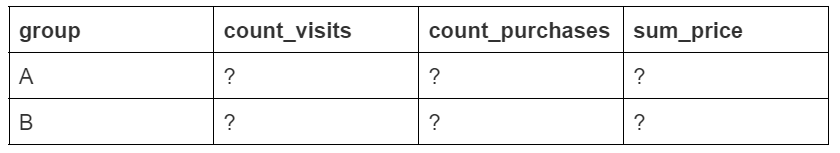
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
group_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
group_data.head()

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

После очистки данных, число посетителей сайта в группе А уменьшилось до 145307 человек, а в группе B до 145381 человек. Разница в количестве посетителей сайта в группах А и B примерно одинаково, разница ничтожна (около 0,05%). Поэтому можно утверждать, что выборка сбалансирована.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
group_data['conversion'] = (group_data['count_purchases'] / group_data['count_visits']) * 100
group_data['mean_check'] = group_data['sum_price'] / group_data['count_purchases']
group_data.head()
# как мы видим из таблицы, конверсия в группах равна 12.03 (группа А) и 11.9 (группа B)
# как мы видим из таблицы, средний чек в группах равен 81076 рублей (группа А) и 88665 рублей (группа B)

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Сделаем промежуточные выводы. По показателю конверсии покупки, группа А эффективнее группы B. По показателю среднего чека, наоборот, группа B эффективнее группы А.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
cons_data = updated_data.pivot_table(
    values='purchase',
    index='group',
    columns='price',
    aggfunc='count',
    fill_value=0
).round()
cons_data

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,127820,5182,5271,1832,3478,1724
B,128091,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

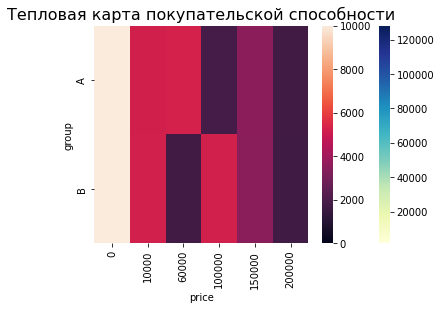

In [11]:
heatmap = sns.heatmap(data=cons_data, cmap='YlGnBu')
ax = sns.heatmap(cons_data, vmin=0, vmax=10000)
heatmap.set_title('Тепловая карта покупательской способности', fontsize=16);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Заметные различия по покупательской способности у туров за 60000 рублей, для группы А они более предпочтительней. Туры же за 100000 рублей, наоборот, более предпочтительны для группы B. В остальных случаях, сильной разницы в покупательской способности между группами нет.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
data_dg = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
data_dg['conversion'] = (data_dg['count_purchases'] / data_dg['count_visits']) * 100
data_dg['mean_check'] = data_dg['sum_price'] / data_dg['count_purchases']
data_dg.head()
data_dg[(data_dg['date'] == '2021-01-03')]
# Конверсия 3 января 2021 года в группе А равна 11,34, а в группе B равна 11,39. Средний чек за 3 января 2021
# года равен в группе А 82887 рублей, а в группе B - 87480 рублей.

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
data_dg['conversion'] = (data_dg['count_purchases'] / data_dg['count_visits']) * 100
data_dg['mean_check'] = data_dg['sum_price'] / data_dg['count_purchases']
data_dg['cum_count_visits'] = data_dg.groupby(['group'])['count_visits'].cumsum()
data_dg['cum_count_purchases'] = data_dg.groupby(['group'])['count_purchases'].cumsum()
data_dg['cum_sum_price'] = data_dg.groupby(['group'])['sum_price'].cumsum()
data_dg['cum_convertion'] = data_dg['cum_count_purchases'] / data_dg['cum_count_visits'] * 100
data_dg['cum_mean_check'] = data_dg['cum_sum_price'] / data_dg['cum_count_purchases']
data_dg[(data_dg['date'] == '2021-01-20')]
# Куммулятивная конверсия в группе B на 20 января равняется 11,89
data_dg[(data_dg['date'] == '2021-01-12')]
# Куммулятивный средний чек в группе A на 12 января равняется 81492 рубля


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_convertion,cum_mean_check
20,2021-01-12,A,6540,795,68460000,12.155963,86113.207547,68852,8198,668070000,11.906698,81491.827275
21,2021-01-12,B,6635,807,70560000,12.162773,87434.944238,69251,8236,727670000,11.892969,88352.355512


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

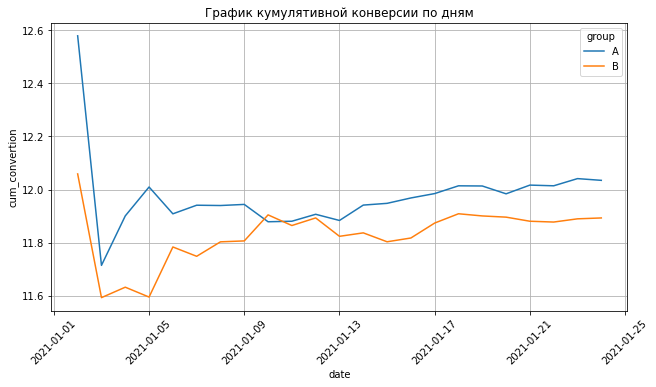

In [14]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_convertion', data=data_dg, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

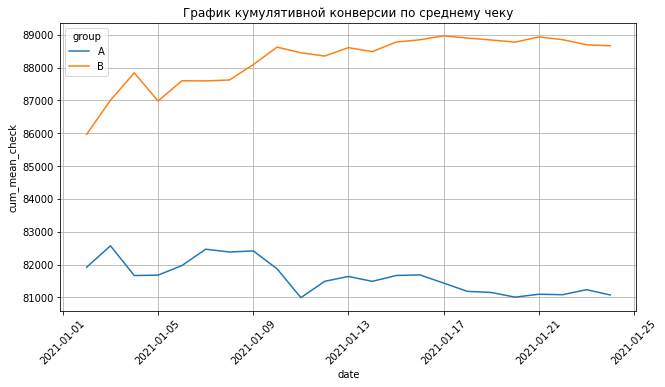

In [15]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=data_dg, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по среднему чеку')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

График куммулятивной конверсии по дням сначала подвержен сильному колебанию, но после 13 января стабилизируется. График куммулятивной конверсии по среднему чеку так же в начале подвержен колебаниям, но примерно с 11 января резкие скачки прекращаются и график стабилизируется. На этом основании можно сделать вывод, что длительность проведенного эксперимента была адекватной для того, чтобы судить о статистической разности показателей в группах. Что касается разницы между показателями в группах, то можно видеть, что ежедневная куммулятивная конверсия выше у группы А, ежедневный средний чек выше у группы B.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [16]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05
_, p_value = proportions_ztest(
    count=group_data['count_purchases'],
    nobs=group_data['count_visits'],
    alternative='larger'
)
print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Для проверки гипотезы о равенстве конверсий в группе применим z-тест, поскольку объемы выборки превышает 30. Результаты z-теста говорят нам о том, что статистической разницы между конверсиями групп A и B нет. 

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [17]:
a_updated_data = updated_data[updated_data['group'] == 'A']
b_updated_data = updated_data[updated_data['group'] == 'B']
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)
conf_interval_a = proportions_conf_interval(
n=a_updated_data['user_id'].count(), # размер выборки
x_p=a_updated_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_updated_data['user_id'].count(), # размер выборки
x_p=b_updated_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [26]:
def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma
    diff = xp[1] - xp[0]
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5
    lower_bound = diff - eps
    upper_bound = diff + eps
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)
n = [a_updated_data['user_id'].count(), b_updated_data['user_id'].count()]
xp = [a_updated_data['purchase'].mean(), b_updated_data['purchase'].mean()]
diff_inverval = diff_conversion_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительный интервал для конверсии группы А: 11.87, 12.2. Доверительный интервал для конверсии группы B: 11.73, 12.06. Это значит, что реальное значение конверсии лежит в рамках указанных промежутков. Уже здесь мы видим, что эти интервалы пересекаются, а это значит, что можно утверждать, что конверсия группы A не отличается от конверсии группы B. Об этом же нам говорит и доверительный интервал для разности конверсий, который охватывает точку 0, что значит, что средний чек групп А и B равнозначны.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [23]:
a_check_data_dg = data_dg[data_dg['group'] == 'A']
b_check_data_dg = data_dg[data_dg['group'] == 'B']
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
_, p = shapiro(a_check_data_dg['mean_check'])
print('p=%.3f' % p)
if p > alpha:
	print(H0)
else:
	print(Ha)
# показатели среднего чека в группе А распределены нормально

p=0.253
Данные распределены нормально


In [24]:
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
_, p = shapiro(b_check_data_dg['mean_check'])
print('p=%.3f' % p)
if p > alpha:
	print(H0)
else:
	print(Ha)
# показатели среднего чека в группе B распределены нормально

p=0.094
Данные распределены нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [25]:
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05
print('\n' + "*** Результаты независимого T-теста ***")
test_results = ttest_ind(a_check_data_dg['mean_check'], b_check_data_dg['mean_check'], alternative='less')
print('p-value:', round(test_results.pvalue, 2))
p = round(test_results[1],2)
if p>alpha:
    print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}")
else:
    print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {H1}")


*** Результаты независимого T-теста ***
p-value: 0.0
0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Т-тест говорит о том, существует статистическая разница между ежедневными средними чеками в обеих группах. Средний чек в группе B значимо больше, чем в группе A.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [27]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1
    alpha = 1 - gamma
    t_crit = -t.ppf(alpha/2, k)
    eps = t_crit * x_std / n**0.5
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    return round(lower_bound), round(upper_bound)
params_a = {
    'n': a_check_data_dg['count_visits'].count(),
    'x_mean': a_check_data_dg['mean_check'].mean(),
    'x_std': a_check_data_dg['mean_check'].std()
}
params_b = {
    'n': b_check_data_dg['count_visits'].count(),
    'x_mean': b_check_data_dg['mean_check'].mean(),
    'x_std': b_check_data_dg['mean_check'].std()
}
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительные интервалы для средних чеков обеих групп не пересекаются, что дает нам повод делать утверждение о значимой статистической разнице средних чеков: в группе B он явно выше.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Исходя из рассмотренных данных, можно сделать следующие выводы:
- в обеих разновидностях сайта покупают одинаковое количество туров
- в варианте сайта, который предназначался для группы B, покупают более дорогие туры (чаще всего не в Турцию, а в Таиланд).
Из этого следует, что вариант сайта B более привлекателен в плане продаж более дорогих туров. Можно выбрать его для постоянного использования, но, скорее, лучшим решением было бы проведение дополнительного эксперимента для потверждения полученных выводов.